# Checking convergence in DisMod-MR

This notebook provides some examples of running multiple chains and checking convergence in DisMod-MR.  Checking convergence is an important part of MCMC estimation.

In [1]:
import numpy as np, pandas as pd, dismod_mr, pymc as pm, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

In [2]:
# set a random seed to ensure reproducible simulation results
np.random.seed(123456)

In [3]:
# simulate data
n = 20

data = dict(age=np.random.randint(0, 10, size=n)*10,
            year=np.random.randint(1990, 2010, size=n))
data = pd.DataFrame(data)
data['value'] = (.1 + .001 * data.age) + np.random.normal(0., .01, size=n)

data['data_type'] = 'p'

data['age_start'] = data.age
data['age_end'] = data.age+10

# for prettier display, include jittered age near midpoint of age interval
data['jittered_age'] = .5*(data.age_start + data.age_end) + np.random.normal(size=n)

# keep things simple, no spatial random effects, no sex effect
data['area'] = 'all'
data['sex'] = 'total'

# quantification of uncertainty that says these numbers are believed to be quite precise
data['standard_error'] = -99
data['upper_ci'] = np.nan
data['lower_ci'] = np.nan
data['effective_sample_size'] = 1.e8


def new_model(data):
    # build the dismod_mr model
    dm = dismod_mr.data.ModelData()

    # set simple model parameters, for decent, fast computation
    dm.set_knots('p', [0,100])
    dm.set_level_bounds('p', lower=0, upper=1)
    dm.set_level_value('p', age_before=0, age_after=100, value=0)
    dm.set_heterogeneity('p', value='Slightly')
    dm.set_effect_prior('p', cov='x_sex', value=dict(dist='Constant', mu=0))
    
    # copy data into model 
    dm.input_data = data.copy()
    
    return dm

# Fit the model with too few iterations of MCMC

using stored FE for beta_p_x_sex x_sex {'dist': 'Constant', 'mu': 0}
finding initial values


/ihme/homes/abie/projects/2019/dismod_mr/dismod_mr/model/covariates.py:84: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  U = U.select(lambda col: (U[col].max() > 0) and (model.hierarchy.node[col].get('level') > model.hierarchy.node[root_area]['level']), axis=1)  # drop columns with only zeros and which are for higher levels in hierarchy
/ihme/homes/abie/projects/2019/dismod_mr/dismod_mr/model/covariates.py:98: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  U = U.select(lambda col: 1 <= U[col].sum() < len(U[col]) or col in keep, axis=1)
/ihme/homes/abie/projects/2019/dismod_mr/dismod_mr/model/covariates.py:187: FutureWarning: 'select' is deprecated and will be removed in a future release. You can use .loc[labels.map(crit)] as a replacement
  X = input_data.select(lambda col: col.startswith('x_'), axis=1)
/ihme/homes/

. . . 
finding MAP estimate

finding step covariances estimate

resetting initial values (1)
. . . 
resetting initial values (2)

mare: 0.04
sampling from posterior

CPU times: user 3.91 s, sys: 15.2 ms, total: 3.93 s
Wall time: 3.93 s


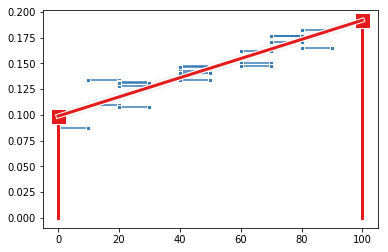

In [4]:
dm1 = new_model(data)
dm1.setup_model('p', rate_model='neg_binom')
%time dm1.fit(how='mcmc', iter=10, burn=0, thin=1)
dm1.plot()

Fitting it again gives a different answer:

using stored FE for beta_p_x_sex x_sex {'dist': 'Constant', 'mu': 0}
finding initial values
. . . 
finding MAP estimate

finding step covariances estimate

resetting initial values (1)
. . . 
resetting initial values (2)

mare: 0.04
sampling from posterior

CPU times: user 3.64 s, sys: 4.82 ms, total: 3.64 s
Wall time: 3.64 s


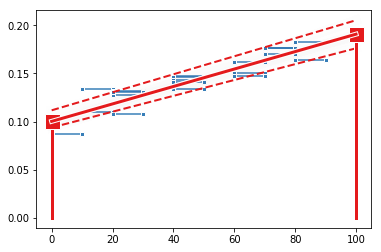

In [5]:
dm2 = new_model(data)
dm2.setup_model('p', rate_model='neg_binom')
%time dm2.fit(how='mcmc', iter=10, burn=0, thin=1)
dm2.plot()

In [6]:
dm1.vars['p']['gamma'][1].trace().mean()

-1.6510577815764151

In [7]:
dm2.vars['p']['gamma'][1].trace().mean()

-1.6575645158607852

# Fit with more MCMC iterations

In [8]:
dm1 = new_model(data)
dm1.setup_model('p', rate_model='neg_binom')
%time dm1.fit(how='mcmc', iter=10_000, burn=5_000, thin=5)

using stored FE for beta_p_x_sex x_sex {'dist': 'Constant', 'mu': 0}
finding initial values
. . . 
finding MAP estimate

finding step covariances estimate

resetting initial values (1)
. . . 
resetting initial values (2)

mare: 0.04
sampling from posterior

CPU times: user 49.3 s, sys: 39.1 ms, total: 49.3 s
Wall time: 49.6 s


In [9]:
dm2 = new_model(data)
dm2.setup_model('p', rate_model='neg_binom')
%time dm2.fit(how='mcmc', iter=10_000, burn=5_000, thin=5)

using stored FE for beta_p_x_sex x_sex {'dist': 'Constant', 'mu': 0}
finding initial values
. . . 
finding MAP estimate

finding step covariances estimate

resetting initial values (1)
. . . 
resetting initial values (2)

mare: 0.04
sampling from posterior

CPU times: user 49.2 s, sys: 13.7 ms, total: 49.2 s
Wall time: 49.9 s


In [10]:
dm1.vars['p']['gamma'][1].trace().mean()

-1.6509666197921975

In [11]:
dm2.vars['p']['gamma'][1].trace().mean()

-1.6503391252889006

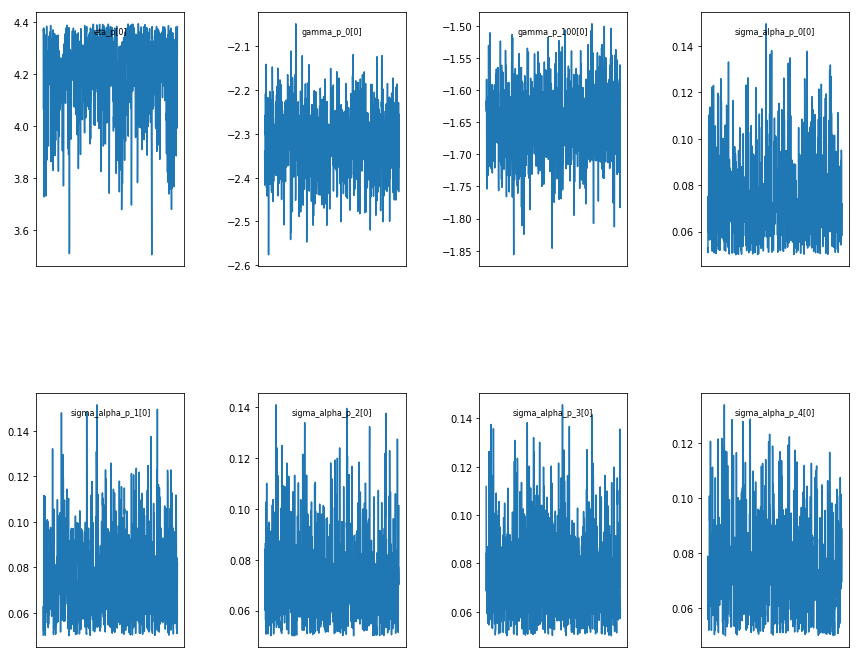

In [12]:
dismod_mr.plot.plot_trace(dm1)

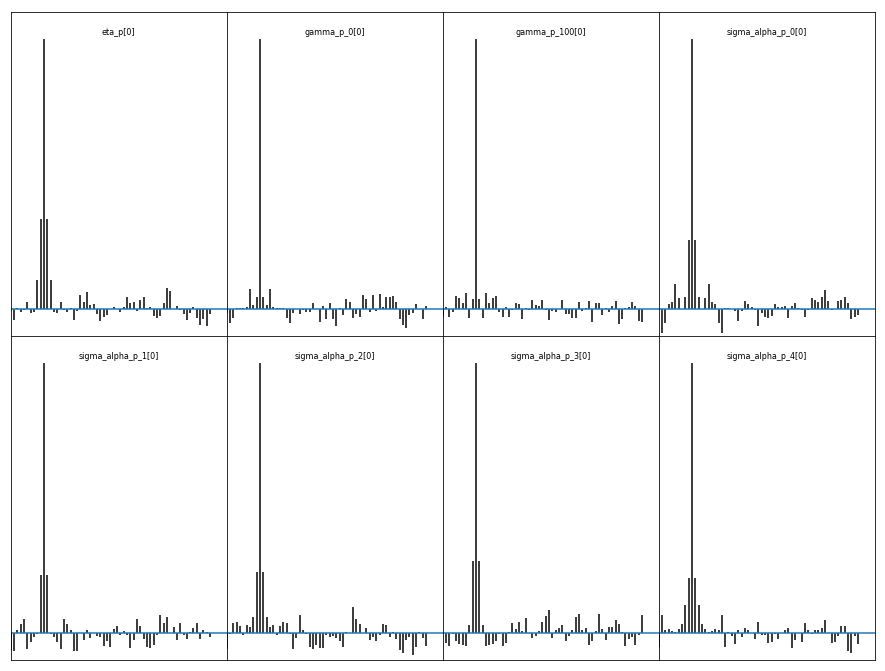

In [13]:
dismod_mr.plot.plot_acorr(dm1)

# Running multiple chains

It is simple to run multiple chains sequentially in DisMod-MR, although I worry that this gives a false sense of security about the convergence.

In [14]:
# setup a model and run the chain once

dm = new_model(data)
dm.setup_model('p', rate_model='neg_binom')
%time dm.fit(how='mcmc', iter=2_000, burn=1_000, thin=1)

using stored FE for beta_p_x_sex x_sex {'dist': 'Constant', 'mu': 0}
finding initial values
. . . 
finding MAP estimate

finding step covariances estimate

resetting initial values (1)
. . . 
resetting initial values (2)

mare: 0.04
sampling from posterior

CPU times: user 12.9 s, sys: 5.99 ms, total: 12.9 s
Wall time: 13.3 s


In [15]:
# to run it more times, use the sample method of the dm.mcmc object
# use the same iter/burn/thin settings for future convenience

for i in range(4):
    dm.mcmc.sample(iter=2_000, burn=1_000, thin=1)

 [-----------------100%-----------------] 2000 of 2000 complete in 9.8 sec

In [16]:
# calculate Gelman-Rubin statistic for all model variables
R_hat = pm.gelman_rubin(dm.mcmc)

# examine for gamma_p_100
R_hat['gamma_p_100']

0.9994731475996127

In [17]:
!date

Mon Jun 17 17:30:11 PDT 2019
